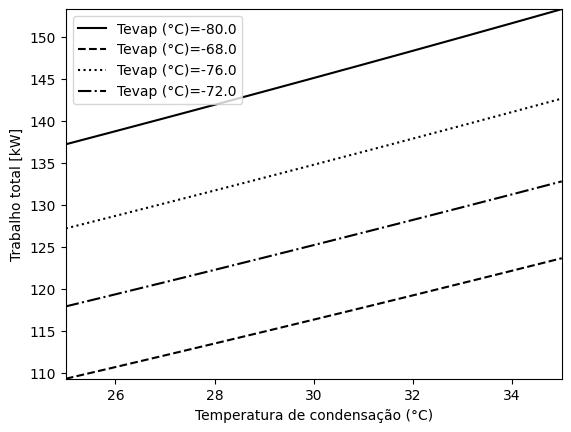

In [6]:
from CoolProp.CoolProp import PropsSI as COOLPROP
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
import math
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T1_lista = []
T8_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#temperaturas de condensação
for i in range (25, 36, 1):
    cont.append(i+273.15)

#Parâmetros
Pfrig = 120 * 1000 #[W]
T3 = -24 + 273.15 #[K]
T10 = -29 + 273.15 #[K]
fluid_high = 'R600'
fluid_low = 'R170'
N = 0.7
drop_suc = 1 #[Pa]
drop_desc = 0 #[Pa]
efet = 0.7 #efetividade do trocador intermediário
DeltaT = 0 #[°C]

#Pressão crítica do fluido do ciclo de alta pressão
P_crit_high = COOLPROP('PCRIT', fluid_high)

#Ciclo de baixa pressão
P3 = COOLPROP('P', 'T', T3, 'Q', 0 , fluid_low)
P2 = P3
Pc = P2 + drop_desc
h3 = COOLPROP('H', 'T', T3, 'Q', 0, fluid_low)
h4 = h3

#Ciclo de alta pressão
P10 = COOLPROP('P', 'T', T10, 'Q', 1, fluid_high)
P5 = P10
h5 = COOLPROP('H', 'P', P5, 'Q', 1, fluid_high)
cp5 = COOLPROP('CP0MASS', 'P', P5, 'Q', 1, fluid_high)
T5 = COOLPROP('T', 'P', P5, 'Q', 1, fluid_high)

#Variação das temperaturas de evaporação e condensação
for T1 in range (-80, -67, 4):
    #Ciclo de baixa pressão
    T1 = T1 + 273.15
    P1 = COOLPROP('P', 'T', T1, 'Q', 1, fluid_low)
    r1 = P2/P1
    h1 = COOLPROP('H', 'T', T1, 'Q', 1, fluid_low)
    ha = h1
    Pa = P1 - drop_suc
    Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
    Pb = Pa
    Tb = Ta + DeltaT
    hb = COOLPROP('H', 'T', Tb, 'P', Pb, fluid_low)
    Sb = COOLPROP('S', 'T', Tb, 'P', Pb, fluid_low)
    m_flow_low = Pfrig / (h1 - h4)
    Pc = P2 + drop_desc
    Sc_ideal = Sb     
    hc_ideal = COOLPROP('H', 'S', Sc_ideal , 'P', Pc, fluid_low)
    hc_real = (hc_ideal - hb)/N + hb
    h2 = hc_real
    #Trabalho específico no compressor do ciclo de baixa pressão
    w_low = hc_real - hb
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador central
    Qcond_low =  m_flow_low * (h2 - h3)
    for T8 in cont:
        #Ciclo de alta pressão
        Qevap_high = Qcond_low
        P8 = COOLPROP('P', 'T', T8, 'Q', 0, fluid_high)
        cp8 = COOLPROP('CP0MASS', 'T', T8, 'Q', 0, fluid_high)
        h8 = COOLPROP('H', 'T', T8, 'Q', 0, fluid_high)
        P6 = P5
        P9 = P8
        
        #Comparação entre os calores específicos nos pontos 8 e 5
        if cp5 < cp8:
            T6 = efet * (T8 - T5) + T5
            h6 = COOLPROP('H', 'T', T6, 'P', P6, fluid_high)
            hw = h6
            Pw = P6 - drop_suc
            Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_high)
            Px = Pw
            Tx = Tw + DeltaT
            hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_high)
            sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_high)
            
            P7 = P8
            Py = P7 + drop_desc
            sy_ideal = sx
            hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_high)
            hy_real = (hy_ideal - hx)/N + hx
            h7 = hy_real
        
            h9 = h8 + h5 - h6
            T9 = COOLPROP('T', 'H', h9, 'P', P9, fluid_high)
            h10 = h9
        else:
            T9 = T8 - efet * (T8 - T5)
            h9 = COOLPROP('H', 'T', T9, 'P', P9, fluid_high)
            h6 = h8 + h5 - h9
            T6 = COOLPROP('T', 'H', h6, 'P', P6, fluid_high)
            hw = h6
            Pw = P6 - drop_suc
            Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_high)
            Px = Pw
            Tx = Tw + DeltaT
            hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_high)
            sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_high)
        
            P7 = P8
            Py = P7 + drop_desc
            sy_ideal = sx
            hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_high)
            hy_real = (hy_ideal - hx)/N + hx
            h7 = hy_real
            
            h10 = h9
                       

        r2 = P7/P6
        m_flow_high = Qevap_high / (h5 - h10)

        #Verificação da pressão crítica
        if P_crit_high > P7:
            T1_lista.append(T1 - 273.15)
            T8_lista.append(T8 - 273.15)
            #Trabalho específico no compressor do ciclo de alta pressão
            w_high = hy_real - hx
            #Trabalho no compressor do ciclo de alta pressão
            Wcomp_high = m_flow_high * w_high
            #Trabalho total
            Wcomp_total = Wcomp_low + Wcomp_high
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P7 = {:0.2f} kPa (T1 = {:0.2f}°C, T8 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} logo o ponto não foi incluído no gráfico'
                   .format(P7/1000,T1-273.15,T8-273.15,fluid_high))

x = T8_lista
z = T1_lista
y = Wcomp_total_lista

# Define um dicionário que mapeia os valores de z para estilos de linha diferentes
z_linestyles = {z_val: linestyle for z_val, linestyle in zip(set(z), ['-','--', ':', '-.'])}

# Cria uma figura com um gráfico 2D
fig, ax = plt.subplots()

# Itera sobre os valores únicos de z
for z_val in set(z):
    # Seleciona os pontos correspondentes a z_val
    x_val = [x[i] for i in range(len(x)) if z[i] == z_val]
    y_val = [y[i] for i in range(len(y)) if z[i] == z_val]

    # Plota os pontos com uma linha ligando eles
    ax.plot(x_val, y_val, linestyle=z_linestyles[z_val], color='black', label=f'Tevap (°C)={z_val}')

# Define os limites dos eixos X e Y
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

# Define os rótulos dos eixos X e Y
ax.set_xlabel('Temperatura de condensação (°C)')
ax.set_ylabel('Trabalho total [kW]')

# Adiciona a legenda
ax.legend()


# Mostra o gráfico
plt.show()

